In [33]:
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import torch
from model import CaT
import inference
import pandas as pd
import matplotlib.pyplot as plt
from datasets import get_full_ordering, reorder_dag
import utils

shuffling = 0
seed = 1
standardize = 0
sample_size = 1000000
batch_size = 100
max_iters = 100000
eval_interval = 100
eval_iters = 100
validation_fraction = 0.3
np.random.seed(seed=seed)
torch.manual_seed(seed)
device = 'cuda'
dropout_rate = 0.0
learning_rate = 5e-3
ff_n_embed = 4
num_heads = 1
n_layers = 1
head_size = 4
d = 1

def generate_data(N, d=3):
    DAGnx = nx.DiGraph()
    
    Ux = np.random.randn(N,d)
    X =  Ux
    
    Ub = np.random.randn(N,d)
    B =  Ub
    
    Uc = np.random.randn(N,d)
    C =  Uc
    
    Uy = np.random.randn(N,d)
    Y = 0.3 * X + 0.6 * B + 1.2 * C +  Uy

    Y0 = 0.3 * 0 + 0.6 * B + 1.2 * C +  Uy
    Y1 =  0.3 * 1 + 0.6 * B + 1.2 * C + Uy

    all_data_dict = {'X': X, 'B': B, 'C': C, 'Y': Y}

    # types can be 'cat' (categorical) 'cont' (continuous) or 'bin' (binary)
    var_types = {'X': 'cont', 'B': 'cont', 'C': 'cont', 'Y': 'cont'}

    DAGnx.add_edges_from([('X', 'Y'), ('B', 'Y'), ('C', 'Y')])
    DAGnx = reorder_dag(dag=DAGnx)  # topologically sorted dag
    var_names = list(DAGnx.nodes())  # topologically ordered list of variables
    all_data = np.stack([all_data_dict[key] for key in var_names], axis=1)
    causal_ordering = get_full_ordering(DAGnx)
    ordered_var_types = dict(sorted(var_types.items(), key=lambda item: causal_ordering[item[0]]))

    return all_data, DAGnx, var_names, causal_ordering, ordered_var_types, Y0, Y1



def get_batch(train_data, val_data, split, device, batch_size):
    data = train_data if split == 'train' else val_data
    ix = torch.randint(0, len(data), (batch_size,))
    x = data[ix]
    return x.to(device)

all_data, DAGnx, var_names, causal_ordering, var_types, Y0, Y1 = generate_data(N=sample_size, d=d)
indices = np.arange(0, len(all_data))
np.random.shuffle(indices)

val_inds = indices[:int(validation_fraction*len(indices))]

train_inds = indices[int(validation_fraction*len(indices)):]
train_data = all_data[train_inds]
val_data = all_data[val_inds]
train_data, val_data = torch.from_numpy(train_data).float(),  torch.from_numpy(val_data).float()
input_dim = all_data.shape[2]
    
model = CaT(input_dim=input_dim,
                dropout_rate=dropout_rate,
                head_size=head_size,
                num_heads=num_heads,
                ff_n_embed=ff_n_embed,
                dag=DAGnx,
                causal_ordering=causal_ordering,
                n_layers=n_layers,
                device=device,
                var_types=var_types,
                ).to(device)
    


torch.Size([1, 4, 1])
torch.Size([1, 4, 1])
torch.Size([1, 4, 1])
torch.Size([1, 4, 1])
torch.Size([1, 4, 1])


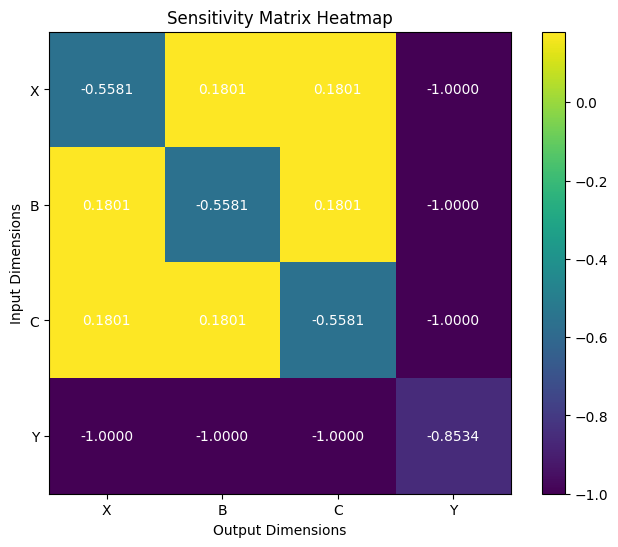

In [34]:
def input_output_sensitivity_matrix(input, model, epsilon=1.0):
    model.eval()
    input = input.detach().clone() 
    original_output, _, _ = model(X=input, targets=input, shuffling=False)
    
    sensitivity_matrix = torch.zeros((input.size(1), original_output.size(1)))

    for i in range(input.size(1)): 
        perturbed_input = input.clone()
        perturbed_input[0, i] += epsilon  
        
        perturbed_output, _, _ = model(X=perturbed_input, targets=perturbed_input, shuffling=False)
    
        output_difference = perturbed_output - original_output

        sensitivity_matrix[i, :] = output_difference.view(-1)
    
    return sensitivity_matrix


def normalize_matrix_abs(sensitivity_matrix):
    # Avoid division by zero by using np.where
    row_max = np.max(np.abs(sensitivity_matrix), axis=1, keepdims=True)
    normalized_matrix = np.where(row_max != 0, sensitivity_matrix / row_max, 0)
    return normalized_matrix


xb = get_batch(train_data=train_data, val_data=val_data, split='train', device=device, batch_size=1) * 0.0 + 1
sensitivity_matrix = normalize_matrix_abs(input_output_sensitivity_matrix(xb, model).detach().cpu().numpy())

plt.figure(figsize=(8, 6))
plt.imshow(sensitivity_matrix, cmap='viridis', interpolation='nearest')
plt.colorbar()

for i in range(sensitivity_matrix.shape[0]):
    for j in range(sensitivity_matrix.shape[1]):
        plt.text(j, i, f'{sensitivity_matrix[i, j]:.4f}', ha='center', va='center', color='white')

plt.xlabel('Output Dimensions')
plt.ylabel('Input Dimensions')
plt.title('Sensitivity Matrix Heatmap')
plt.xticks(ticks=np.arange(len(var_names)), labels=var_names)
plt.yticks(ticks=np.arange(len(var_names)), labels=var_names)
# Display the plot
plt.show()